Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29#

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, \
roc_auc_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings(action='ignore')

#### Оригинальная база данных рака молочной железы штата Висконсин

Информация об атрибутах:

1. Кодовый номер образца: идентификационный номер
2. Толщина комка: 1 - 10
3. Однородность размера клеток: 1 - 10
4. Однородность формы клеток: 1 - 10
5. Маргинальная адгезия: 1 - 10
6. Размер единичных эпителиальных клеток : 1 - 10
7. Голые ядра: 1 - 10
8. Чистый хроматин: 1 - 10
9. Нормальные ядрышки: 1 - 10
10. Митозы: 1 - 10
11. Класс: (2 для доброкачественных, 4 для злокачественных)

In [2]:
data = pd.read_csv("breast-cancer-wisconsin.data", header=None)
data.columns = ['Sample code number', 
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class'
               ]
#data.index = data['Sample code number']
data = data.iloc[:, 1:]
data.head(3)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2


In [3]:
data.loc[data['Class']==2, 'Class'] = 0
data.loc[data['Class']==4, 'Class'] = 1
data.head(3)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0


У нас есть 9 признаков и 1 целевая переменная (бинарная) - нужно определить доброкачественная опухоль или нет

In [4]:
# проверим отсутствие пропусков

data.describe().iloc[0, :]

Clump Thickness                699.0
Uniformity of Cell Size        699.0
Uniformity of Cell Shape       699.0
Marginal Adhesion              699.0
Single Epithelial Cell Size    699.0
Bland Chromatin                699.0
Normal Nucleoli                699.0
Mitoses                        699.0
Class                          699.0
Name: count, dtype: float64

In [5]:
# проверим тип данных

data.dtypes

Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [6]:
data['Bare Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [7]:
# заполним пропуски медианным значением

data.loc[data['Bare Nuclei']=='?', 'Bare Nuclei'] = \
data.loc[data['Bare Nuclei']!='?', 'Bare Nuclei'].median()
data['Bare Nuclei'] = data['Bare Nuclei'].astype('int64')

In [8]:
data.shape

(699, 10)

Всего 699 пациэнток

Посмотрим на соотношение классов

In [9]:
data.iloc[:, -1].value_counts()

0    458
1    241
Name: Class, dtype: int64

Разбиваем выборку на тренировочную и тестовую части и обучаем модель

In [10]:
x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = \
train_test_split(x_data, y_data, test_size=0.25, random_state=42)

In [11]:
model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[17:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))
    
    return {'f1_score': f1, 'recall': rec, 'precision':prc}

In [17]:
model_1 = evaluate_results(y_test, y_predict)

Classification results:
f1: 92.86%
recall: 91.23%
precision: 94.55%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [19]:
mod_data = data.copy()

# получим индексы положительных образцов
pos_ind = np.where(mod_data.iloc[:, -1].values == 1)[0]

# перемешаем их
np.random.shuffle(pos_ind)

# оставьте только 30% положительных результатов
pos_sample_len = int(np.ceil(0.3 * pos_ind.shape[0]))

print(f'Использование {pos_sample_len}/{pos_ind.shape[0]} \
в качестве положительных результатов и снятие маркировки с остальных')

pos_sample = pos_ind[: pos_sample_len]

Использование 73/241 в качестве положительных результатов и снятие маркировки с остальных


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [20]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    626
 1     73
Name: class_test, dtype: int64


*  73 позитива и 626 без разметки -1.

*  0-9 столбцы-признаки описания датасета, 4-й столбей истиной разметки, 5-й (class_test) разметка на входе задачи PUL 

In [21]:
mod_data.tail(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,class_test
689,1,1,1,1,2,1,1,1,8,0,-1
690,1,1,1,3,2,1,1,1,1,0,-1
691,5,10,10,5,4,5,4,4,1,1,1
692,3,1,1,1,2,1,1,1,1,0,-1
693,3,1,1,1,2,1,2,1,2,0,-1
694,3,1,1,1,3,2,1,1,1,0,-1
695,2,1,1,1,2,1,1,1,1,0,-1
696,5,10,10,3,7,3,8,10,2,1,-1
697,4,8,6,4,3,4,10,6,1,1,-1
698,4,8,8,5,4,5,10,4,1,1,-1


Отделими [:-2] как истиный класс для проверки, и  [:-1] как данные для входной разметки PUL

In [22]:
x_data = mod_data.iloc[:,:-2].values # только X 
y_labeled = mod_data.iloc[:,-1].values # класс для PUL ( P & U)
y_positive = mod_data.iloc[:,-2].values # истиная разметка

### 1. random negative sampling

In [23]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(73, 11) (73, 11)


In [24]:
sample_train.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,class_test
524,3,1,1,1,2,1,2,1,1,0,-1
237,9,8,8,5,6,2,4,10,4,1,1
198,1,1,1,1,2,1,1,1,1,0,-1
63,6,3,4,1,5,2,3,9,1,1,1
673,5,3,2,1,3,1,1,1,1,0,-1


In [25]:
model = xgb.XGBClassifier()
sample_train.loc[sample_train['class_test']==-1,'class_test']=0
model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-1].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
model_2 = evaluate_results(sample_test.iloc[:,-2].values, y_predict)

[17:36:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 86.43%
recall: 81.76%
precision: 91.67%


{'f1_score': 0.8642857142857143,
 'recall': 0.8175675675675675,
 'precision': 0.9166666666666666}

#### Сравним модели

In [29]:
pd.DataFrame([model_1, model_2], index = ['model_1', 'model_2'])

,f1_score,recall,precision
model_1,0.928571,0.912281,0.945455
model_2,0.864286,0.817568,0.916667


#### Вывод: model_1 - лучшая модель

Проверим, как будет меняться качество модели при изменении размера P

In [26]:
def func(data, percent):
    
    def evaluate_results(y_test, y_predict):
        f1 = f1_score(y_test, y_predict)
        rec = recall_score(y_test, y_predict, average='binary')
        prc = precision_score(y_test, y_predict, average='binary')
        return {'f1_score': f1, 'recall': rec, 'precision':prc}
    
    mod_data = data.copy()
    # получим индексы положительных образцов
    pos_ind = np.where(mod_data.iloc[:, -1].values == 1)[0]
    # перемешаем их
    np.random.shuffle(pos_ind)
    # оставьте только 30% положительных результатов
    pos_sample_len = int(np.ceil(percent * pos_ind.shape[0]))
    pos_sample = pos_ind[: pos_sample_len]
    
    # Создаем столбец для новой целевой переменной, 
        # где у нас два класса - P (1) и U (-1)
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
    # Отделими [:-2] как истиный класс для проверки, и [:-1] 
        # как данные для входной разметки PUL
    x_data = mod_data.iloc[:,:-2].values # только X 
    y_labeled = mod_data.iloc[:,-1].values # класс для PUL ( P & U)
    y_positive = mod_data.iloc[:,-2].values # истиная разметка
    
    # 1. random negative sampling
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    model = xgb.XGBClassifier()
    sample_train.loc[sample_train['class_test']==-1,'class_test']=0
    model.fit(sample_train.iloc[:,:-2].values, 
              sample_train.iloc[:,-1].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    
    return evaluate_results(sample_test.iloc[:,-2].values, y_predict)

In [60]:

df = pd.DataFrame({percent: func(data, percent) for percent in np.linspace(0.1, 0.9, 9)})
df

[18:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:03:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
f1_score,0.804290,0.836923,0.849624,0.834043,0.843243,0.881119,0.795699,0.800000,0.717949
recall,0.724638,0.764045,0.795775,0.809917,0.838710,0.926471,0.880952,0.933333,1.000000
precision,0.903614,0.925170,0.911290,0.859649,0.847826,0.840000,0.725490,0.700000,0.560000


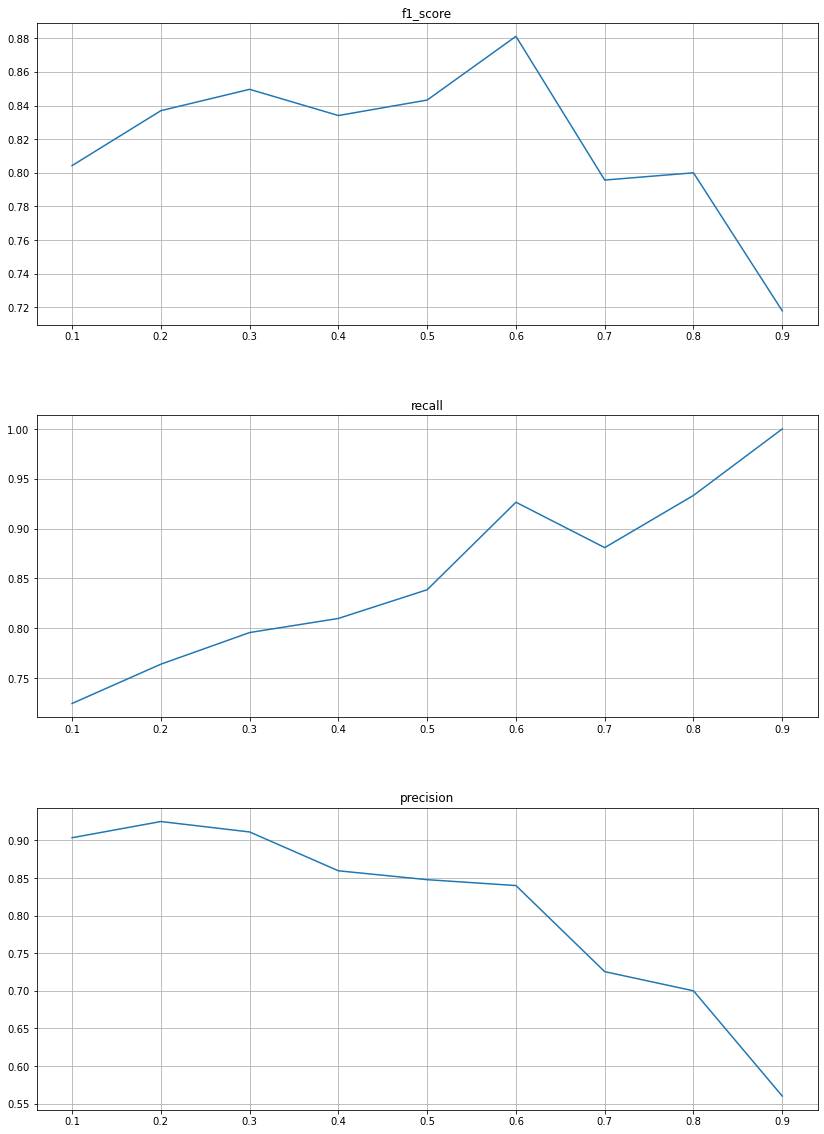

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=3, ncols=1)
ax1, ax2, ax3 = ax.flatten()

ax1.plot(df.iloc[0, :])
ax1.set_title('f1_score')
ax1.grid()

ax2.plot(df.iloc[1, :])
ax2.set_title('recall')
ax2.grid()

ax3.plot(df.iloc[2, :])
ax3.set_title('precision')
ax3.grid()

fig.set_size_inches(14, 20)
plt.subplots_adjust(wspace=.3, hspace=.3)

### Вывод :
##### с увеличением percent:
* точность уменьшаестя
* полнота растет
* их среднее гармоническое достигает максимума при средних значениях